In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clear-data/train.csv
/kaggle/input/clear-data/test.csv
/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold



In [4]:
train=pd.read_csv("/kaggle/input/clear-data/train.csv")
test=pd.read_csv("/kaggle/input/clear-data/test.csv")

In [5]:
numerical_features = test.select_dtypes(include=['number']).columns
categorical_cols = test.select_dtypes(exclude=['number']).columns

test[numerical_features] = test[numerical_features].fillna(test[numerical_features].mean())

for col in categorical_cols:
    if test[col].isnull().any():
        test[col] = test[col].fillna(test[col].mode()[0])

In [6]:
train.shape

(18524, 9)

In [7]:
# Social Engagement Score (interaction term)
train['Social_score'] = (train['Social_event_attendance'] + train['Going_outside'] + train['Friends_circle_size'])
# Introvert-Tendency Proxy
train['Introvert_score'] = (train['Time_spent_Alone'] - train['Social_score'])
train['Inp']=train['Introvert_score']-train['Post_frequency']
train['set']=train['Social_event_attendance']-train['Time_spent_Alone']
train['In_ex']=train['Stage_fear']+train['Drained_after_socializing']
train['tsd']=train['Time_spent_Alone']+train['Stage_fear']+train['Drained_after_socializing']

# Social Engagement Score (interaction term)
test['Social_score'] = (test['Social_event_attendance'] + test['Going_outside'] + test['Friends_circle_size'])
# Introvert-Tendency Proxy
test['Introvert_score'] = (test['Time_spent_Alone'] - test['Social_score'])
test['Inp']=test['Introvert_score']-test['Post_frequency']
test['set']=test['Social_event_attendance']-test['Time_spent_Alone']
test['In_ex']=test['Stage_fear']+test['Drained_after_socializing']
test['tsd']=test['Time_spent_Alone']+test['Stage_fear']+test['Drained_after_socializing']

In [8]:
def team(a):
    if a<0:
        return 0
    else:
        return 1
train['team']=train['set'].apply(team)
test['team']=test['set'].apply(team)
def intro(a):
    if a>0:
        return 1
    else:
        return 0
train['intro']=train['In_ex'].apply(intro)
test['intro']=test['In_ex'].apply(intro)
def tsd_filter(a):
    if a==5:
        return 0
    elif a<5:
        return 0
    else:
        return 1
train['tsd_filter']=train['tsd'].apply(tsd_filter)
test['tsd_filter']=test['tsd'].apply(tsd_filter)

In [9]:
test.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Social_score,Introvert_score,Inp,set,In_ex,tsd,team,intro,tsd_filter
0,18524,3.0,0.0,7.0,4.0,0.0,6.0,7.0,17.0,-14.0,-21.0,4.0,0.0,3.0,1,0,0
1,18525,6.0,1.0,0.0,0.0,1.0,5.0,1.0,5.0,1.0,0.0,-6.0,2.0,8.0,0,1,1
2,18526,3.0,0.0,5.0,6.0,0.0,15.0,9.0,26.0,-23.0,-32.0,2.0,0.0,3.0,1,0,0
3,18527,3.0,0.0,4.0,4.0,0.0,5.0,6.0,13.0,-10.0,-16.0,1.0,0.0,3.0,1,0,0
4,18528,9.0,1.0,1.0,2.0,1.0,1.0,1.0,4.0,5.0,4.0,-8.0,2.0,11.0,0,1,1


In [10]:
train=train.drop('id',axis=1)

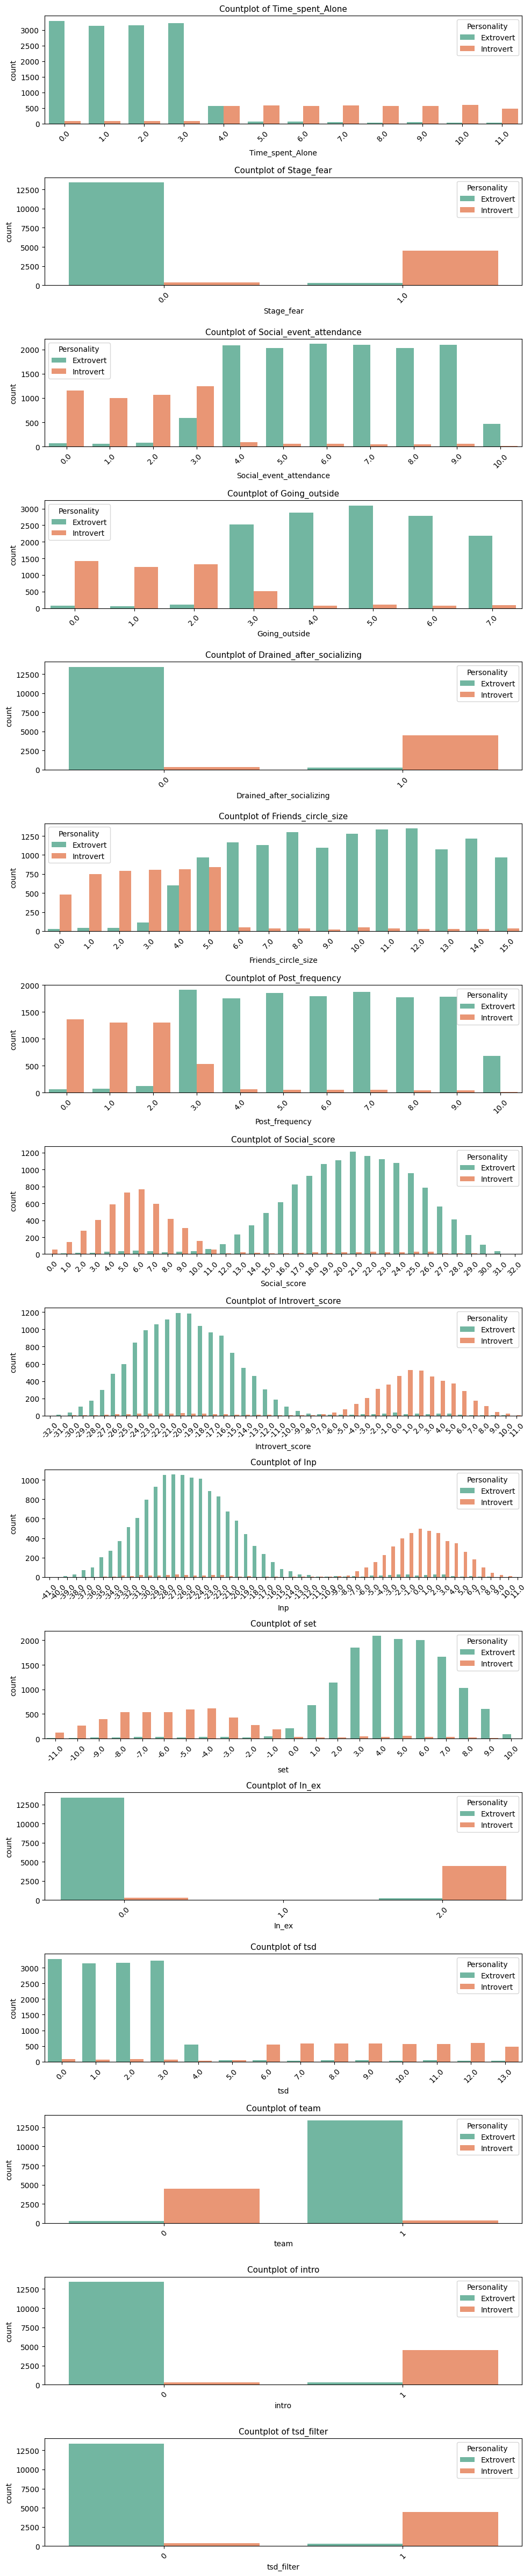

In [11]:
numerical_cols = train.select_dtypes(include=['number']).columns
#fig, ax = plt.subplots(5,1,figsize=(10, 15))
fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(10, 3 * len(numerical_cols)))

#numerical_cols = train.select_dtypes(include=['number']).columns

for i, col in enumerate(numerical_cols):
    sns.countplot(x=col, data=train, ax=ax[i], palette="Set2", hue="Personality")
    ax[i].set_title(f"Countplot of {col}", fontsize=11)
    ax[i].tick_params(axis="x" , rotation=45)

plt.tight_layout()
plt.show()

In [12]:
X=train.drop(['Personality'],axis=1)

y_t=train['Personality']

In [13]:
y=le.fit_transform(y_t)
y

array([0, 0, 1, ..., 1, 1, 0])

In [14]:
x=test.drop('id',axis=1)

In [15]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

x_scale = scaler.transform(x)

In [16]:




# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    # Create model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Cross-validation
    score = cross_val_score(clf, X_scale, y, cv=5, scoring='accuracy').mean()
    return score

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Show best result
print("Best trial:")
trial = study.best_trial

print(f"  Accuracy: {trial.value}")
# Store best hyperparameters in a dictionary
best_params = {}

print("Best hyperparameters:")
for key, value in trial.params.items():
    best_params[key] = value
    print(f"  {key}: {value}")



[I 2025-07-24 06:47:13,082] A new study created in memory with name: no-name-949b7deb-cda2-4fd9-b559-dc737a8bb191
[I 2025-07-24 06:47:24,168] Trial 0 finished with value: 0.9690674268325742 and parameters: {'n_estimators': 166, 'max_depth': 24, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.9690674268325742.
[I 2025-07-24 06:47:28,766] Trial 1 finished with value: 0.9691214225129196 and parameters: {'n_estimators': 69, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9691214225129196.
[I 2025-07-24 06:47:41,774] Trial 2 finished with value: 0.9688515024061234 and parameters: {'n_estimators': 190, 'max_depth': 21, 'min_samples_split': 15, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9691214225129196.
[I 2025-07-24 06:47:46,334] Trial 3 finished with value: 0.9690134457259614 and parameters: {'n_estimators': 158, 'max_depth': 3, 'm

Best trial:
  Accuracy: 0.9692293701524122
Best hyperparameters:
  n_estimators: 59
  max_depth: 24
  min_samples_split: 16
  min_samples_leaf: 10
  max_features: log2


In [17]:
model=RandomForestClassifier(**best_params)

In [18]:


# Initialize Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# List to store the accuracies for each fold
accuracies = []

# Stratified K-Fold Cross-Validation
for train_index, test_index in skf.split(X_scale, y):
    # Split the dataset into training and testing sets for each fold
    X_train, X_test = X_scale[train_index], X_scale[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the Voting Classifier model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the accuracy for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Output the average accuracy across all folds
print(f"Average Accuracy across {n_splits} folds: {np.mean(accuracies):.4f}")

# Final Classification Report (using the whole dataset, but typically, you may compute on the final model)
model.fit(X_scale, y)  # Fit on the whole data for final model
final_predictions = model.predict(X_scale)
print("Final Classification Report on Entire Dataset:\n", classification_report(y, final_predictions))

Average Accuracy across 5 folds: 0.9691
Final Classification Report on Entire Dataset:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     13699
           1       0.95      0.94      0.94      4825

    accuracy                           0.97     18524
   macro avg       0.96      0.96      0.96     18524
weighted avg       0.97      0.97      0.97     18524



In [19]:
model.fit(X_scale,y)

RandomForestClassifier(max_depth=24, max_features='log2', min_samples_leaf=10,
                       min_samples_split=16, n_estimators=59)

<Axes: >

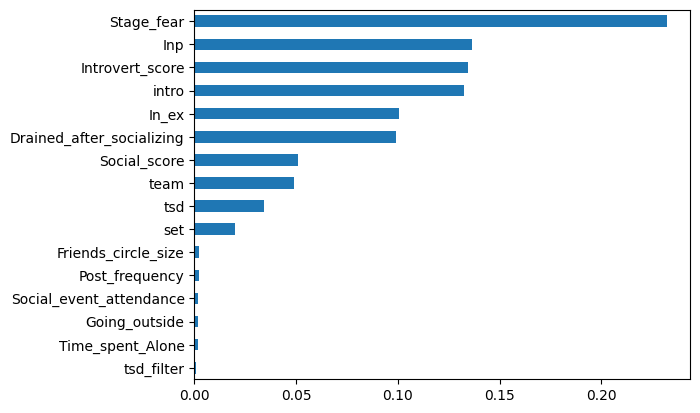

In [20]:

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh')


In [21]:
pred=model.predict(x_scale)
pred

array([0, 1, 0, ..., 0, 0, 1])

In [22]:
predictions=le.inverse_transform(pred)
predictions

array(['Extrovert', 'Introvert', 'Extrovert', ..., 'Extrovert',
       'Extrovert', 'Introvert'], dtype=object)

In [23]:
output = pd.DataFrame({'id': test.id, 'Personalities': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [24]:
sub=pd.read_csv("submission.csv")
sub.head()

,id,Personalities
0,18524,Extrovert
1,18525,Introvert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
